# Platt Scaling

In [91]:
%matplotlib notebook
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle':'--'})
np.random.seed(1)
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [4]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls',
                  header=1)

target = 'default payment next month'
features = [x for x in df.columns if x not in (target, 'ID')]

In [83]:
X, y = load_breast_cancer().data, load_breast_cancer().target
X, y = df[features], df[target]

print('Number of total samples:    {}'.format(X.shape[0]))
print('Number of positive samples: {}'.format(y.sum()))
# do some undersampling, to make the class more balanced
idx_neg = X[y==0].sample(y.sum()).index.values
idx_pos = X[y==1].index.values
idx = np.concatenate([idx_neg, idx_pos])
X = X.iloc[idx, :].reset_index(drop=True)
y = y.iloc[idx].reset_index(drop=True)

platt = False
X_train, X_test, y_train, y_test = train_test_split(X, y)
if platt:
    X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train)

clfs = [
(RandomForestClassifier(n_estimators=200, max_depth=10), 'Random Forrst'),
(GradientBoostingClassifier(n_estimators=200, max_depth=10), 'GradBoost'),
(xgb.XGBClassifier(n_estimators=200, max_depth=10), 'xgb'),
(AdaBoostClassifier(n_estimators=200), 'AdaBoost')
]


def fitting(X, y, clf, platt=False):
    print('====== {} ====='.format(clf.__class__.__name__))
    print("Training...")   
    clf.fit(X, y)    
    print('AUC on train set: {:6.3f}'.format(
        roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])))
    print('AUC on test set:  {:6.3f}'.format(
        roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))
    

for x in clfs:
    fitting(X_train, y_train, x[0], True)

Number of total samples:    30000
Number of positive samples: 6636
====== RandomForestClassifier =====
Training...
AUC on train set:  0.893
AUC on test set:   0.790
====== GradientBoostingClassifier =====
Training...
AUC on train set:  1.000
AUC on test set:   0.769
====== XGBClassifier =====
Training...
AUC on train set:  0.999
AUC on test set:   0.774
====== AdaBoostClassifier =====
Training...
AUC on train set:  0.807
AUC on test set:   0.773


<IPython.core.display.Javascript object>


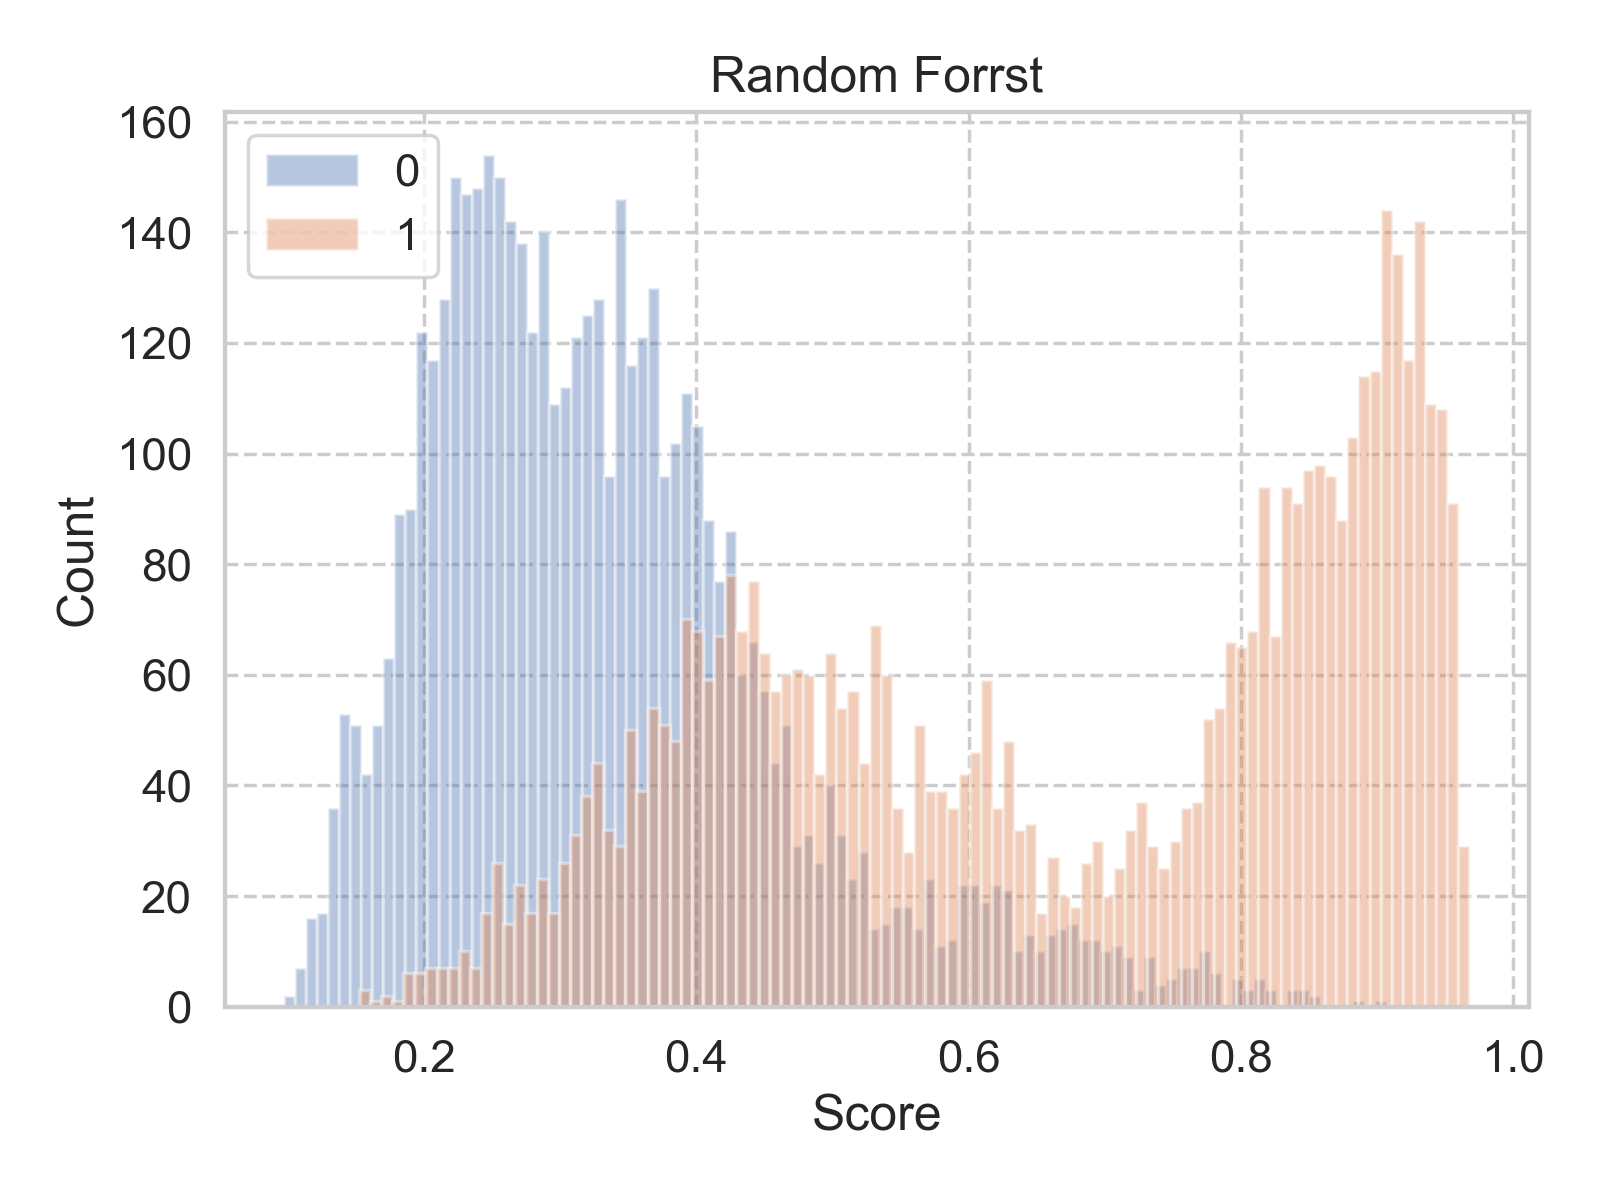

<IPython.core.display.Javascript object>


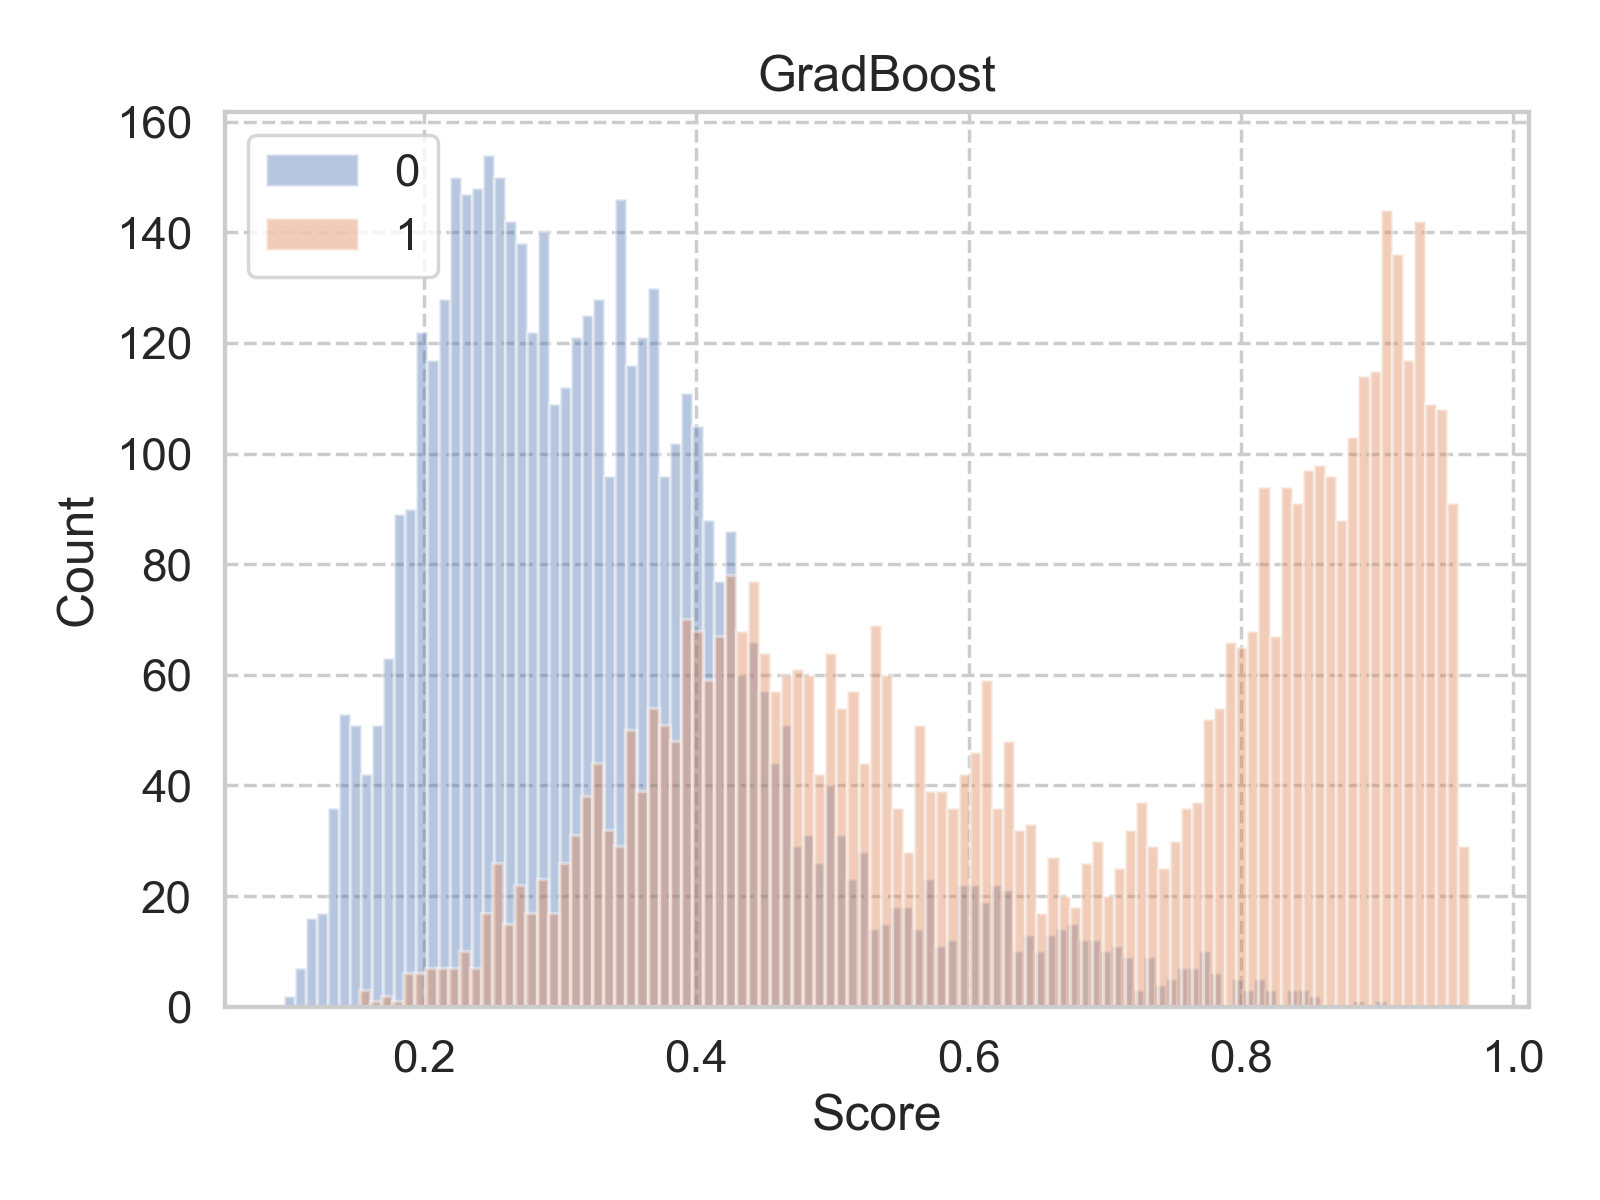

<IPython.core.display.Javascript object>


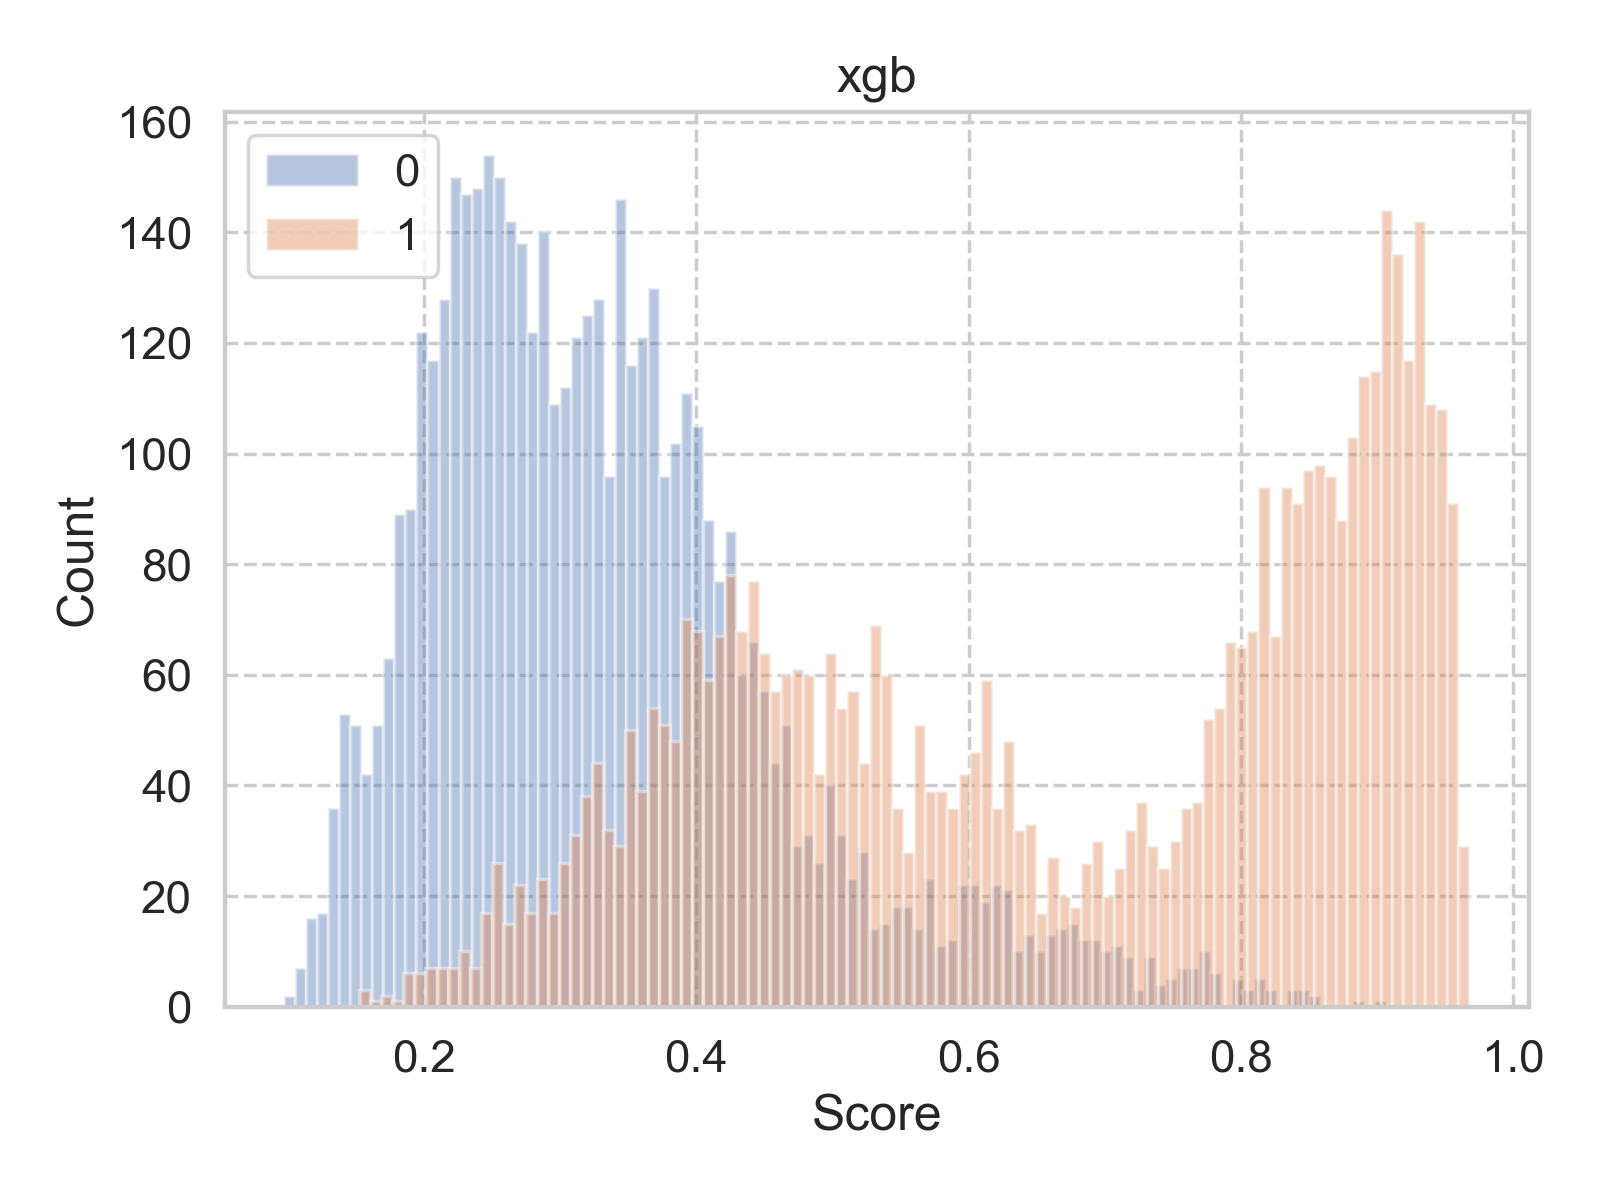

<IPython.core.display.Javascript object>


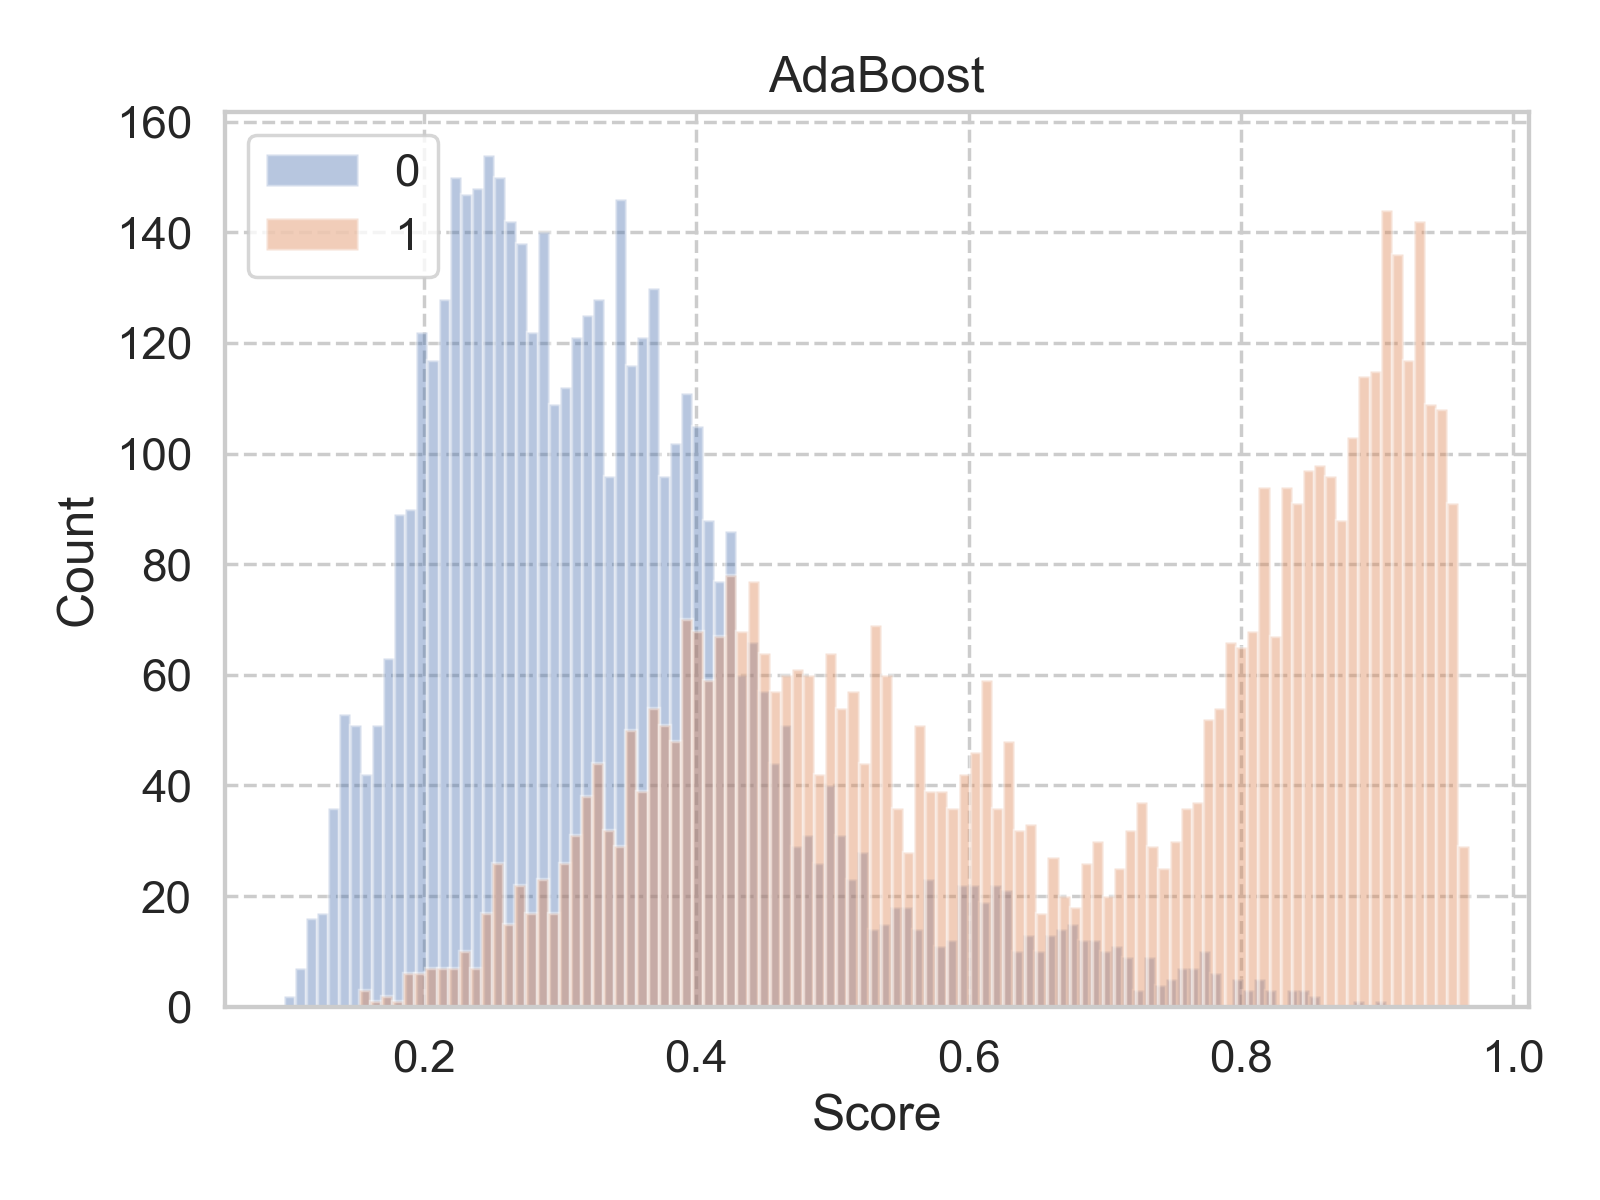

In [107]:
def plot_prob_dist(y_pred, y_true, label='', fig_num=0):
    plt.close(fig_num)
    plt.figure(fig_num)
    df = pd.DataFrame(data={'pred':clfs[0][0].predict_proba(X_train)[:,1], 
                   'true':y_train.values})
    sns.distplot(df[df['true']==0]['pred'], kde=False, bins=100, label='0')
    sns.distplot(df[df['true']==1]['pred'], kde=False, bins=100, label='1')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.title(label)
    plt.legend()
    plt.tight_layout()

for i, x in enumerate(clfs):
    plot_prob_dist(x[0].predict_proba(X_train)[:, 1], y_train, x[1], i)


<IPython.core.display.Javascript object>


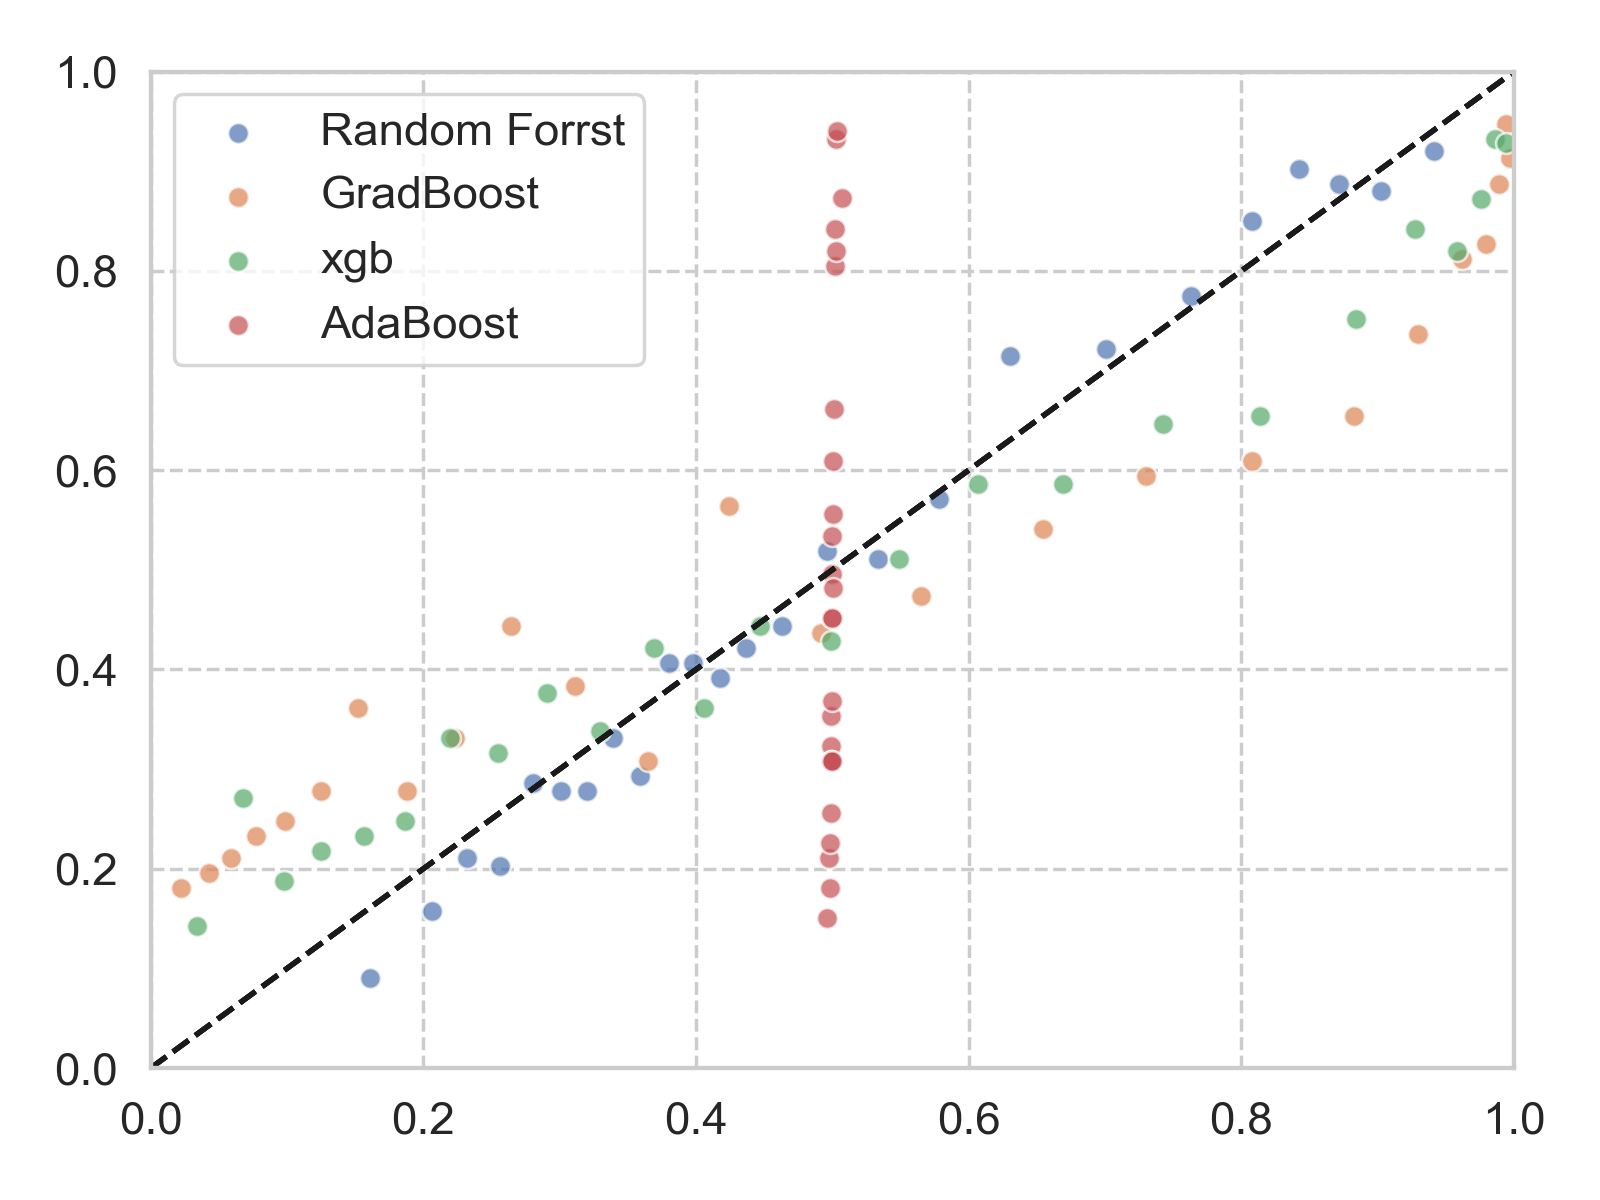

In [120]:
def reliability_diagram(y_true, y_pred, N=25):
    paired = np.c_[y_pred, y_true]
    paired = paired[np.argsort(paired[:,0])]
    length = paired.shape[0]
    mean_proba, mean_true = [], []
    start_idx = 0
    size = int(np.ceil(length/N))
    while start_idx < length:
        mean_proba.append(paired[start_idx:start_idx+size, 0].mean())
        mean_true.append(paired[start_idx:start_idx+size, 1].mean())
        start_idx += size
    return (mean_proba, mean_true)

def plot_reliability_diagram(mean_proba, mean_true, label='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    sns.scatterplot(mean_proba, mean_true, sizes=50, alpha=0.7, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()

fig, ax = plt.subplots()
for i, x in enumerate(clfs):
    plot_reliability_diagram(
        *reliability_diagram(y_test, x[0].predict_proba(X_test)[:,1]), x[1], ax=ax)